In [1]:
# EE569 HOMEWORK ASSIGNMENT 6
# DATE: Aprile 30th 2021
# NAME: Siyu Li
# ID:2455870216
# E-mail:lisiyu@usc.edu
# mnist
# implement pixelhop++ by cwSaab
from pixelhop import Pixelhop
import numpy as np
from skimage.util import view_as_windows
import pickle
from skimage.measure import block_reduce
import xgboost as xgb
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist,fashion_mnist
import warnings, gc
import seaborn as sns

In [2]:
np.random.seed(1)

# Preprocess
N_Train_Reduced = 10000    # 10000
N_Train_Full = 60000     # 50000
N_Test = 10000            # 10000

BS = 10000 # batch size


def shuffle_data(X, y):
    shuffle_idx = np.random.permutation(y.size)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y


def select_balanced_subset(images, labels, use_num_images):
    '''
    select equal number of images from each classes
    '''
    num_total, H, W, C = images.shape
    num_class = np.unique(labels).size
    num_per_class = int(use_num_images / num_class)

    # Shuffle
    images, labels = shuffle_data(images, labels)

    selected_images = np.zeros((use_num_images, H, W, C))
    selected_labels = np.zeros(use_num_images)

    for i in range(num_class):
        selected_images[i * num_per_class:(i + 1) * num_per_class] = images[labels == i][:num_per_class]
        selected_labels[i * num_per_class:(i + 1) * num_per_class] = np.ones((num_per_class)) * i

    # Shuffle again
    selected_images, selected_labels = shuffle_data(selected_images, selected_labels)

    return selected_images, selected_labels

def Shrink(X, shrinkArg):
    #---- max pooling----
    pool = shrinkArg['pool']
    # TODO: fill in the rest of max pooling
    X=block_reduce(X,(1,pool,pool,1),np.max)
    
    #---- neighborhood construction
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    pad = shrinkArg['pad']
    ch=X.shape[-1]
    # TODO: fill in the rest of neighborhood construction
    if pad>0:
        X=np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'reflect')
    X=view_as_windows(X,(1,win,win,ch),(1,stride,stride,ch))
    return X.reshape(X.shape[0],X.shape[1],X.shape[2],-1)

# example callback function for how to concate features from different hops
def Concat(X, concatArg):
    return X

def get_feat(X, num_layers=3):
    output = p2.transform_singleHop(X,layer=0)
    if num_layers>1:
        for i in range(num_layers-1):
            output = p2.transform_singleHop(output, layer=i+1)
    return output


In [3]:
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    # ---------- Load MNIST data and split ----------
    (x_train, y_train), (x_test,y_test) = mnist.load_data()


    # -----------Data Preprocessing-----------
    x_train = np.asarray(x_train,dtype='float32')[:,:,:,np.newaxis]
    x_test = np.asarray(x_test,dtype='float32')[:,:,:,np.newaxis]
    y_train = np.asarray(y_train,dtype='int')
    y_test = np.asarray(y_test,dtype='int')

    # if use only 10000 images train pixelhop
    x_train_reduced, y_train_reduced = select_balanced_subset(x_train, y_train, use_num_images=N_Train_Reduced)

    x_train /= 255.0
    x_test /= 255.0


    # -----------Module 1: set PixelHop parameters-----------
    # TODO: fill in this part

    SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'cw':False}, 
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True}]
    shrinkArgs = [{'func':Shrink, 'win':5, 'stride':1, 'pad':2,'pool':1}, 
             {'func': Shrink, 'win':5, 'stride':1, 'pad':0, 'pool':2},
             {'func': Shrink, 'win':5, 'stride':1,'pad':0, 'pool':2}]
    concatArg = {'func':Concat}
    

    # -----------Module 1: Train PixelHop -----------
    # TODO: fill in this part
   
    p2 = Pixelhop(depth=3, TH1=0.005, TH2=0.001, SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
    p2.fit(x_train_reduced)

    
    # --------- Module 2: get only Hop 3 feature for both training set and testing set -----------
    # you can get feature "batch wise" and concatenate them if your memory is restricted
    # TODO: fill in this part
    split_train_arr=[]
    
    for i in range(6):
        temp=get_feat(x_train[i*BS:(i+1)*BS,:,:,:],3)
        split_train_arr.append(temp)
    train_hop3_feats=np.concatenate((split_train_arr[0],split_train_arr[1],split_train_arr[2],split_train_arr[3]
                                     ,split_train_arr[4],split_train_arr[5]),axis=0)
    
    
    
    #train_hop3_feats=get_feat(x_train,3)
    test_hop3_feats=get_feat(x_test,3)
    
    ### Get Model Size
    h1=get_feat(x_train_reduced,1).shape
    h2=get_feat(x_train_reduced,2).shape
    h3=get_feat(x_train_reduced,3).shape
    
    k1=h1[3]
    k2=h2[3]
    k3=h3[3]
    
    print('k1: ', k1)
    print('k2: ', k2)
    print('k3: ', k3)
    # --------- Module 2: standardization
    STD = np.std(train_hop3_feats, axis=0, keepdims=1)
    train_hop3_feats = train_hop3_feats/STD ## size: (60000,1,1,70)
    #print(np.shape(train_hop3_feats))
    #STDtest = np.std(test_hop3_feats, axis=0, keepdims=1)
    test_hop3_feats = test_hop3_feats/STD
    
    #---------- Module 3: Train XGBoost classifier on hop3 feature ---------
    start_time = time.time()
    tr_acc = []
    te_acc = []
    
    clf = xgb.XGBClassifier(n_jobs=-1,
                        objective='multi:softprob',
                        # tree_method='gpu_hist', gpu_id=None,
                        max_depth=6,n_estimators=100,
                        min_child_weight=5,gamma=5,
                        subsample=0.8,learning_rate=0.1,
                        nthread=8,colsample_bytree=1.0)
    clf.fit(np.squeeze(train_hop3_feats), np.squeeze(y_train))


    end_time = time.time()
    print('training time is ', end_time - start_time)
    # TODO: fill in the rest and report accuracy
    score = clf.score(np.squeeze(train_hop3_feats), np.squeeze(y_train))
    print('Training Set 60000 Predicted score =', score)
    
    score = clf.score(np.squeeze(test_hop3_feats), np.squeeze(y_test))
    print('Test Set Predicted score =', score)
    
    
  

=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
k1:  24
k2:  109
k3:  128
[20:36:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training time is  283.3898777961731
Training Set 60000 Predicted score = 0.98595
Test Set Predicted score = 0.9649


[[9.670e-01 0.000e+00 2.000e-03 0.000e+00 1.000e-03 3.000e-03 4.000e-03
  1.000e-03 2.000e-03 0.000e+00]
 [0.000e+00 1.126e+00 2.000e-03 0.000e+00 0.000e+00 2.000e-03 1.000e-03
  0.000e+00 3.000e-03 1.000e-03]
 [4.000e-03 1.000e-03 9.970e-01 5.000e-03 1.000e-03 1.000e-03 2.000e-03
  1.000e-02 1.100e-02 0.000e+00]
 [0.000e+00 1.000e-03 4.000e-03 9.720e-01 0.000e+00 8.000e-03 0.000e+00
  1.000e-02 1.300e-02 2.000e-03]
 [0.000e+00 0.000e+00 2.000e-03 0.000e+00 9.560e-01 0.000e+00 4.000e-03
  0.000e+00 4.000e-03 1.600e-02]
 [3.000e-03 1.000e-03 1.000e-03 1.700e-02 1.000e-03 8.510e-01 6.000e-03
  1.000e-03 8.000e-03 3.000e-03]
 [8.000e-03 3.000e-03 2.000e-03 0.000e+00 3.000e-03 4.000e-03 9.340e-01
  0.000e+00 4.000e-03 0.000e+00]
 [0.000e+00 5.000e-03 1.500e-02 5.000e-03 2.000e-03 0.000e+00 0.000e+00
  9.720e-01 5.000e-03 2.400e-02]
 [4.000e-03 0.000e+00 7.000e-03 9.000e-03 1.000e-02 1.000e-02 5.000e-03
  3.000e-03 9.230e-01 3.000e-03]
 [3.000e-03 4.000e-03 0.000e+00 6.000e-03 1.800e-02 1.0

Text(66.5, 0.5, 'predict')

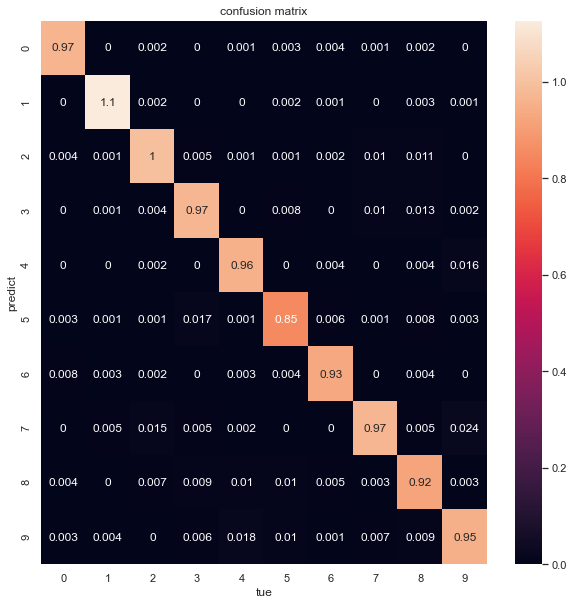

In [9]:
pred = clf.predict(np.squeeze(test_hop3_feats))

sns.set()
f,ax=plt.subplots(figsize=(10, 10))
C2= 10*confusion_matrix(y_test, pred, labels=[0, 1, 2,3,4,5,6,7,8,9],normalize='all')
print(C2) # print the confusion matrix and see 
sns.heatmap(C2,annot=True,ax=ax) #draw heat map

ax.set_title('confusion matrix') # title
ax.set_xlabel('tue') #x axis
ax.set_ylabel('predict') #y axis

Real Class= 9
Predicted Class= 8


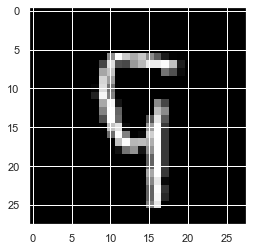

In [5]:
error_image_index_list=[]
for i in range(10000):
    if y_test[i] != pred[i]:
        error_image_index_list.append(i)


print('Real Class=', y_test[error_image_index_list[1]])
print('Predicted Class=', pred[error_image_index_list[1]])

plt.imshow(x_test[error_image_index_list[1]],cmap='gray')
plt.show()

Real Class= 9
Predicted Class= 8


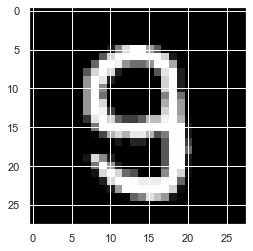

In [6]:
print('Real Class=', y_test[error_image_index_list[2]])
print('Predicted Class=', pred[error_image_index_list[2]])

plt.imshow(x_test[error_image_index_list[2]],cmap='gray')
plt.show()

Real Class= 3
Predicted Class= 5


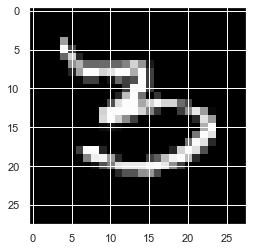

In [7]:
print('Real Class=', y_test[error_image_index_list[3]])
print('Predicted Class=', pred[error_image_index_list[3]])

plt.imshow(x_test[error_image_index_list[3]],cmap='gray')
plt.show()

Real Class= 6
Predicted Class= 0


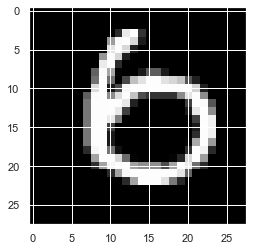

In [8]:
print('Real Class=', y_test[error_image_index_list[4]])
print('Predicted Class=', pred[error_image_index_list[4]])

plt.imshow(x_test[error_image_index_list[4]],cmap='gray')
plt.show()